In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-news-dataset-with-ministry-labels/ministry-classification-model (1).ipynb
/kaggle/input/indian-news-dataset-with-ministry-labels/combined_dataset.csv


In [2]:
!pip install pytorch-lightning

In [3]:
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup,AutoTokenizer,AutoModel

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn import metrics
import warnings

#handling html data
from bs4 import BeautifulSoup
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df = pd.read_csv('/kaggle/input/indian-news-dataset-with-ministry-labels/combined_dataset.csv')
df.head()

,news_num,labels,title,content
0,0,0,"Trainer aircraft crashes in Odisha, 2 killed",A two-seater aircraft crashed in Odisha's Dhen...
1,1,17,Uttarkhand unlock 1.0: Hotel bookings for mini...,Hotels located in non-containment zones can re...
2,2,12,J-K: Four Hizbul militants killed in Shopian e...,9 in last 24 hoursFour militants were killed ...
3,3,"54,33","Mumbai offices to reopen today, with curbs",Private offices in Mumbai are set to reopen on...
4,4,12,"PDP, NC, PC call for release of all J&K leaders",Four days after bureaucrat-turned-politician S...


In [5]:
df.tail()

,news_num,labels,title,content
36046,53709,"9,17","5 dead, hundreds of tourists stranded as heavy...","Five persons, including three police personnel..."
36047,53710,34,Mumbai constable dismissed after arrest in ₹7....,Mumbai Police Commissioner Sanjay Pandey dismi...
36048,60914,6,"Mumbai logs 2,255 new COVID-19 cases, 2 deaths...","Mumbai has reported 2,255 fresh COVID-19 cases..."
36049,60915,23,China's 'zero-COVID' policy likely to persist ...,"Nicholas Burns, the US Ambassador to China, on..."
36050,60916,34,Senior colleagues take turns raping BPO execut...,"Three senior colleagues, two men and a woman, ..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36051 entries, 0 to 36050
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   news_num  36051 non-null  int64 
 1   labels    36051 non-null  object
 2   title     36051 non-null  object
 3   content   36051 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [7]:
label = df.labels

In [8]:
import re
import string


def convint(x):
    return [int(re.sub(f"[{string.punctuation}]","",ele)) for ele in x if ele!=""]

In [9]:
lab = []
for i in label:
    lab.append(convint(i.split(',')))
lab[:10]

[[0], [17], [12], [54, 33], [12], [12], [40, 36], [12], [60], [6]]

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(lab)
yt.shape

(36051, 61)

In [11]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[(0,)]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [12]:
def pre_process(text):
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

df["text"]=df["title"]+" "+df["content"]

In [13]:
x = df["text"].apply(lambda x: pre_process(x))

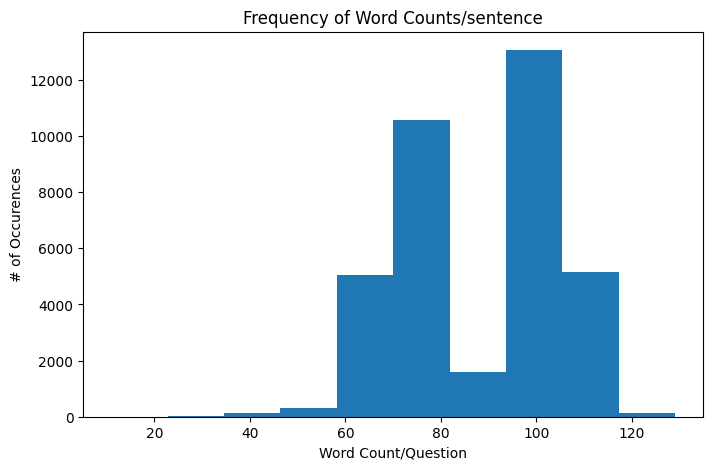

In [14]:
import matplotlib.pyplot as plt
# compute no. of words in each question
questions = x
word_cnt = [len(quest.split()) for quest in questions]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt)
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
df.reset_index(drop=True, inplace=True)
plt.show()

In [15]:
Final_Df = pd.concat([pd.DataFrame(x),pd.DataFrame(yt)],axis=1)

In [16]:
Final_Df

,text,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,trainer aircraft crashes in odisha killed a tw...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,uttarkhand unlock hotel bookings for minimum d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,j k four hizbul militants killed in shopian en...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,mumbai offices to reopen today with curbs priv...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,pdp nc pc call for release of all j k leaders ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36046,dead hundreds of tourists stranded as heavy ra...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36047,mumbai constable dismissed after arrest in cr ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36048,mumbai logs new covid cases deaths positivity ...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36049,china s zero covid policy likely to persist in...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dict_of_num = {}
for i in range(61):
    dict_of_num[i] = Final_Df[i].sum()

In [18]:
dict_of_num

{0: 363,
 1: 175,
 2: 7,
 3: 235,
 4: 480,
 5: 45,
 6: 2104,
 7: 87,
 8: 197,
 9: 482,
 10: 28,
 11: 76,
 12: 613,
 13: 121,
 14: 62,
 15: 53,
 16: 24,
 17: 174,
 18: 2052,
 19: 3,
 20: 855,
 21: 43,
 22: 163,
 23: 2378,
 24: 485,
 25: 21,
 26: 104,
 27: 16,
 28: 27,
 29: 11,
 30: 608,
 31: 43,
 32: 59,
 33: 444,
 34: 5030,
 35: 38,
 36: 229,
 37: 72,
 38: 20,
 39: 5,
 40: 533,
 41: 1552,
 42: 34,
 43: 17,
 44: 695,
 45: 6,
 46: 7,
 47: 379,
 48: 67,
 49: 5,
 50: 22,
 51: 168,
 52: 19,
 53: 107,
 54: 697,
 55: 18,
 56: 6,
 57: 409,
 58: 10,
 59: 27,
 60: 14121}

In [19]:
to_drop = []
for i in dict_of_num:
    if dict_of_num[i]<60:
        to_drop.append(i)
to_drop

[2,
 5,
 10,
 15,
 16,
 19,
 21,
 25,
 27,
 28,
 29,
 31,
 32,
 35,
 38,
 39,
 42,
 43,
 45,
 46,
 49,
 50,
 52,
 55,
 56,
 58,
 59]

The number of ministry we can drop is 27

In [20]:
len(to_drop)

27

#The total number of rows where the unique ministry is less than 60 is 614 which is very less in compare to the 36000 rows of data so we can delete this classes

In [21]:
sums = 0
for i in to_drop:
    sums+=dict_of_num[i]
print(sums)

614


In [22]:
Final_Df.drop(to_drop,axis=1,inplace=True)
Final_Df.head()

,text,0,1,3,4,6,7,8,9,11,...,40,41,44,47,48,51,53,54,57,60
0,trainer aircraft crashes in odisha killed a tw...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,uttarkhand unlock hotel bookings for minimum d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,j k four hizbul militants killed in shopian en...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,mumbai offices to reopen today with curbs priv...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,pdp nc pc call for release of all j k leaders ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are 514 rows in the dataframe where there is no data in the target column so we need to drop that columns

In [23]:
tst = Final_Df.drop('text',axis=1)
rows_to_drop = []
for i in range(len(tst)):
    if tst.iloc[i].sum()==0:
        rows_to_drop.append(i)
len(rows_to_drop)

514

In [24]:
Final_Df.drop(rows_to_drop,axis=0,inplace=True)
len(Final_Df)

35537

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'your_dataframe' is your DataFrame
# Specify the features and target variable
y = Final_Df.drop('text', axis=1)
X = Final_Df['text']

# Split the data into train and test sets with a 50-50 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine features and target variable for training data
train_data = pd.concat([X_train, y_train], axis=1)

# Combine features and target variable for testing data
test_data = pd.concat([X_test, y_test], axis=1)

# Shuffle the training and testing dataframes
train = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test = test_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [26]:
len(train), len(test)

(28429, 7108)

In [27]:
train

,text,0,1,3,4,6,7,8,9,11,...,40,41,44,47,48,51,53,54,57,60
0,films division runs out of space decades of fi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,fighting for a good cause jamia student who st...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,west bengal assembly to pass resolution agains...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,ram madhav to congress don t provoke people ag...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,parliament passes bill to protect rights of tr...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28424,up new infection back to digits fatehpur lates...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28425,haryana contradictions in excise policy recall...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28426,pakistan says manmohan will be invited to kart...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28427,targeted ammo dump launchpads in pok says indi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>here you can change the features but note that do not increase the max_length of word and increasing batch size will increase the ram usage</h1>

In [28]:
# Sections of config

# Defining some key variables that will be used later on in the training
# TOBE CHANGED
MAX_LEN = 120
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [29]:
target_cols = Final_Df.drop('text',axis=1).columns
print(target_cols)
print(len(target_cols))

Index([ 0,  1,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 17, 18, 20, 22, 23, 24,
       26, 30, 33, 34, 36, 37, 40, 41, 44, 47, 48, 51, 53, 54, 57, 60],
      dtype='object')
34


In [30]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.text.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [31]:
test

,text,0,1,3,4,6,7,8,9,11,...,40,41,44,47,48,51,53,54,57,60
0,bjp won t rest till it uproots mamata s tmc fr...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,delhi mumbai could be c warmer in than report ...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,two from fringe hindu outfits among held for k...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,kerala govt moves in to demolish maradu flats ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,brazil president bolsonaro arrives tomorrow pa...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103,must emulate gandhi s dedicated life to make b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7104,slandering of people in higher positions on ri...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7105,former navy chief sushil kumar dies at former ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7106,losing a partner of years was painful neetu on...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, 
                          num_workers=4, shuffle=False, pin_memory=True)

In [34]:
device

device(type='cuda', index=0)

<h1>here you can change the architecture of the model after adding roberta transformer but we have to have the first dense layer of size 768 as the output of bert is of 784 suze</h1>

In [35]:
# # Creating the customized model, by adding a dense layer on top of distil bert to get the final output for the model. 

# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.fc = torch.nn.Linear(768,34)
    
#     def forward(self, ids, mask, token_type_ids):
#         _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output = self.fc(features)
#         return output

# model = BERTClass()
# model = torch.nn.DataParallel(model)
# model.to(device)

In [36]:
from transformers import AutoModel
import torch.nn as nn
import torch

# # Creating the customized model, by adding a dense layer on top of distil bert to get the final output for the model. 

# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.fc = torch.nn.Linear(768,34)
    
#     def forward(self, ids, mask, token_type_ids):
#         _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output = self.fc(features)
#         return output

class BERTClass(nn.Module):
    def __init__(self, hidden_size=768, output_size=34, dropout_prob=0.2):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(p=dropout_prob)
        self.dense = nn.Linear(hidden_size, 100)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(100, output_size)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        
        # Access the pooler output using [0]
        pooled_output = features
        
        # Apply dropout and dense layer
        x = self.dropout(pooled_output)
        x = self.dense(x)
        x = self.relu(x)
        
        # Output layer
        output = self.fc(x)
        return output

# Assuming 'device' is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BERTClass()
model = torch.nn.DataParallel(model)
model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BERTClass(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768,

In [37]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [39]:
def top_n_accuracy(y_true, y_pred_prob, top_n=3):
    length = 0
    true_pred = 0
    k = 0
    for i in range(len(y_true)):
        try:
            top = np.argsort(y_pred_prob[i])[-top_n:]
            a = np.array(y_true[k])
            indices = np.where(a== 1)
            length += len(indices) 
            for j in indices:
                if j in top:
                    true_pred+=1
            k+=1
        except:
            print(k)
    top_n_accuracy = true_pred/length
    return top_n_accuracy

In [40]:
def check_validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    total_loss = 0.0
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    outputs1 = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs1)
    f1_score_micro = metrics.f1_score(fin_targets, outputs1, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, outputs1, average='macro')
    top3_accuracy = top_n_accuracy(fin_targets, fin_outputs, top_n=3)
    print(f'Loss: {total_loss} Top-3 Accuracy: {top3_accuracy}, Accuracy Score = {accuracy}, F1 Score (Micro) = {f1_score_micro}, "F1 Score (Macro) = {f1_score_macro}')

In [41]:
def train(epoch):
    model.train()
    total_loss = 0.0
    fin_targets = []
    fin_outputs = []
 
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()
        
        # Compute accuracy
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        
        if _ % 500 == 0:
            print(f'Epoch: {epoch}, Iteration: {_}, Loss: {loss.item()}')

        loss.backward()
        optimizer.step()
    
    # Calculate epoch accuracy
    outputs = np.array(fin_outputs) > 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs)
#     f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
#     f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    average_loss = total_loss / len(train_loader)
    top3 = top_n_accuracy(np.array(fin_targets),outputs,3)
    print(f'Epoch: {epoch},Loss: {average_loss}, Accuracy: {accuracy}%, Top_3_Accuracy: {top3}')
    print('For Validation Data::')
    check_validation()

<h1>Here the data is in training stage</h1>

In [44]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for epoch in range(EPOCHS):
        train(epoch)

Epoch: 0, Iteration: 0, Loss: 0.08253487199544907
Epoch: 0,Loss: 0.08228825473885858, Accuracy: 0.2631467867318583%, Top_3_Accuracy: 0.4753948432938197
For Validation Data::
Loss: 8.55964307114482 Top-3 Accuracy: 0.7718064153066967, Accuracy Score = 0.33033202025886327, F1 Score (Micro) = 0.44945303658996605, "F1 Score (Macro) = 0.08453105264069348
Epoch: 1, Iteration: 0, Loss: 0.07378917187452316
Epoch: 1,Loss: 0.07162710159514728, Accuracy: 0.3840444616412818%, Top_3_Accuracy: 0.563473917478631
For Validation Data::
Loss: 7.907491568475962 Top-3 Accuracy: 0.8027574563871693, Accuracy Score = 0.4084130557118739, F1 Score (Micro) = 0.505654557916381, "F1 Score (Macro) = 0.09383932534496318
Epoch: 2, Iteration: 0, Loss: 0.06657439470291138
Epoch: 2,Loss: 0.06468275101499611, Accuracy: 0.4439129058355904%, Top_3_Accuracy: 0.5938654191142847
For Validation Data::
Loss: 7.6654036194086075 Top-3 Accuracy: 0.8103545301069218, Accuracy Score = 0.43683173888576254, F1 Score (Micro) = 0.5247483

In [43]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    check_validation()

Loss: 10.02710460871458 Top-3 Accuracy: 0.6845807540799099, Accuracy Score = 0.14715813168261113, F1 Score (Micro) = 0.24235403151065799, "F1 Score (Macro) = 0.014741114462076158


In [45]:
# Save the entire model
torch.save(model, 'model.pth')

# Save only the model parameters (state_dict)
torch.save(model.state_dict(), 'model_state_dict.pth')